<a href="https://colab.research.google.com/github/alexandraizhevskaya/Terms_Xlm/blob/main/Terms_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this notebook Transformer-based NLP model is trained to improve quality of xlingual comparison between 2 languages (russian and english) in the science and tech domain 

## Pipeline

* Use a big parallel dataset from this domain (in this case from Yandex) to train a student model (Xlm) to imitate SciBERT that is used for dealing with science & tech texts (a tutorial from sentence-transformers documentation was used) https://github.com/UKPLab/sentence-transformers/blob/master/examples/training/multilingual/make_multilingual.py \
* Create a special triplet dataset (I could not find one) featuring terms from the two languages: A word in English - a similar word in Russian - a not related word. Here I used ru-eng dictionaries to scrape some data\
* Finally, use triplets to finetune the model one more time for finding semantic similarity

In [ ]:
! pip install sentence_transformers
! pip install pdfminer
! python -m pip install pdfminer.six
! pip install bokeh

In [ ]:
import pandas as pd
import numpy as np
import re
import string
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import transformers
from transformers import RobertaTokenizer, RobertaModel, AutoConfig, AutoTokenizer, AutoModelForMaskedLM
from transformers import XLMTokenizer, XLMWithLMHeadModel, T5Tokenizer,  T5Model
from scipy.sparse import csr_matrix as csr
from seaborn import heatmap
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
import torch
import sklearn
torch.cuda.empty_cache()
from sentence_transformers import SentenceTransformer, LoggingHandler, models, evaluation, losses
from torch.utils.data import DataLoader
from sentence_transformers.datasets import ParallelSentencesDataset
from datetime import datetime
import requests
import os
import logging
import sentence_transformers.util
import csv
import gzip
from tqdm.autonotebook import tqdm
import zipfile
import io 
from pdfminer.converter import TextConverter
from pdfminer.pdfinterp import PDFPageInterpreter
from pdfminer.pdfinterp import PDFResourceManager
from pdfminer.pdfpage import PDFPage

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None) # None
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1) Teach model to imitate SciBERT

Firstly, let's create the necessary files from the chosen parallel dataset

In [ ]:
#! unzip /content/1mcorpus.zip

with open('/content/corpus.en_ru.1m.en') as  f:
  txt_en = f.readlines()

with open('/content/corpus.en_ru.1m.ru') as  f:
  txt_ru = f.readlines()

with open('yandex_train', 'a') as f:
  for i, line in enumerate(txt_en[:800000]):
                src_text = txt_en[i].strip()
                trg_text = txt_ru[i].strip()

                if src_text != "" and trg_text != "":
                    
                    f.write("{}\t{}\n".format(src_text, trg_text))

with open('yandex_dev', 'a') as f:
  for i, line in enumerate(txt_en[800000:]):
                src_text = txt_en[i].strip()
                trg_text = txt_ru[i].strip()

                if src_text != "" and trg_text != "":
                    
                    f.write("{}\t{}\n".format(src_text, trg_text))
                    

In [ ]:
! unzip /content/umc-0.1-corpus.zip

with open('/content/umc-0.1-corpus/English-Russian.txt') as f:
  ds = f.readlines()

with open('ds_train', 'a') as f:
  for line in ds[:90000]:
                src_text = line.split('\t')[2]
                trg_text = line.split('\t')[3]

                if src_text != "" and trg_text != "":
                    
                    f.write("{}\t{}\n".format(src_text, trg_text))

with open('ds_dev', 'a') as f:
  for line in ds[90000:]:
                src_text = line.split('\t')[2]
                # print(src_text)
                # break
                trg_text = line.split('\t')[3]

                if src_text != "" and trg_text != "":
                    
                    f.write("{}\t{}\n".format(src_text, trg_text))
              

Now, actually train and save the student model, the code was taken from sentence model tutorial on this

In [ ]:
teacher_model_name = 'allenai/scibert_scivocab_cased'   #Our monolingual teacher model, we want to convert to multiple languages
student_model_name =  'stsb-xlm-r-multilingual' #'xlm-r-distilroberta-base-paraphrase-v1' #'xlm-r-bert-base-nli-stsb-mean-tokens' #'xlm-roberta-base'                 #Multilingual base model we use to imitate the teacher model

max_seq_length = 128   #128             #Student model max. lengths for inputs (number of word pieces)
train_batch_size = 8           #Batch size for training
inference_batch_size = 8          #Batch size at inference
max_sentences_per_language = 800000 #Maximum number of  parallel sentences for training
train_max_sentence_length = 250 #250    #Maximum length (characters) for parallel training sentences

num_epochs = 2                     #Train for x epochs
num_warmup_steps = 10000             #Warumup steps

num_evaluation_steps = 1000          #Evaluate performance after every xxxx steps
dev_sentences = 1000                 #Number of parallel sentences to be used for development


# Define the language codes you would like to extend the model to
source_languages = set(['en'])                      # Our teacher model accepts English (en) sentences
target_languages = set(['ru'])    # We want to extend the model to these new languages. For language codes, see the header of the train file


output_path = '/content/drive/MyDrive/scibert_xlm/'


# This function downloads a corpus if it does not exist




######## Start the extension of the teacher model to multiple languages ########

word_embedding_model1 = models.Transformer(teacher_model_name, max_seq_length=max_seq_length)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model1.get_word_embedding_dimension())
teacher_model = SentenceTransformer(modules=[word_embedding_model1, pooling_model])
teacher_model.to(device)


# we dont need pooling with the chosen model% it already has one 

# word_embedding_model = models.Transformer(student_model_name, max_seq_length=max_seq_length)
# # # Apply mean pooling to get one fixed sized sentence vector
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
# student_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# student_model.to(device)

student_model = SentenceTransformer(student_model_name)
student_model.to(device) 

###### Read Parallel Sentences Dataset ######
train_data = ParallelSentencesDataset(student_model=student_model, teacher_model=teacher_model, batch_size=inference_batch_size, use_embedding_cache=True)
train_files = ['/content/drive/MyDrive/yandex_train']
for train_file in train_files:
    train_data.load_data(train_file, max_sentences=max_sentences_per_language, max_sentence_length=train_max_sentence_length)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MSELoss(model=student_model)



#### Evaluate cross-lingual performance on different tasks #####
# do not evaluate - I have limited memory resources(
    
evaluators = []         #evaluators has a list of different evaluator classes we call periodically

dev_files = ['/content/yandex_dev']
# for dev_file in dev_files:
#     src_sentences = []
#     trg_sentences = []
#     with open(dev_file, 'r', encoding='utf8') as fIn:
#         for line in fIn:
#             splits = line.strip().split('\t')
#             if splits[0] != "" and splits[1] != "":
#                 src_sentences.append(splits[0])
#                 trg_sentences.append(splits[1])


    #Mean Squared Error (MSE) measures the (euclidean) distance between teacher and student embeddings
    # dev_mse = evaluation.MSEEvaluator(src_sentences, trg_sentences, name=os.path.basename(dev_file), teacher_model=teacher_model, batch_size=inference_batch_size)
    # evaluators.append(dev_mse)

    # TranslationEvaluator computes the embeddings for all parallel sentences. It then check if the embedding of source[i] is the closest to target[i] out of all available target sentences
    # dev_trans_acc = evaluation.TranslationEvaluator(src_sentences, trg_sentences, name=os.path.basename(dev_file),batch_size=inference_batch_size)
    # evaluators.append(dev_trans_acc)


##### Read cross-lingual Semantic Textual Similarity (STS) data ####
# all_languages = list(set(list(source_languages)+list(target_languages)))
# sts_data = {}

#Open the ZIP File of STS2017-extended.zip and check for which language combinations we have STS data

# Train the model
student_model.fit(train_objectives=[(train_dataloader, train_loss)],
          # evaluator=evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: np.mean(scores)),
          epochs=num_epochs,
          warmup_steps=num_warmup_steps,
          # evaluation_steps=num_evaluation_steps,
          output_path=output_path,
          save_best_model=True,
          optimizer_params= {'lr': 2e-5, 'eps': 1e-6, 'correct_bias': False}
          )

student_model.save('/content/drive/MyDrive/scibert_xlm8.0')

In [ ]:
teacher_model_name = 'allenai/scibert_scivocab_cased'   #Our monolingual teacher model, we want to convert to multiple languages
student_model_name =  '/content/drive/MyDrive/scibert_xlm8.0' #'xlm-r-distilroberta-base-paraphrase-v1' #'xlm-r-bert-base-nli-stsb-mean-tokens' #'xlm-roberta-base'                 #Multilingual base model we use to imitate the teacher model

max_seq_length = 128   #128             #Student model max. lengths for inputs (number of word pieces)
train_batch_size = 8           #Batch size for training
inference_batch_size = 8          #Batch size at inference
max_sentences_per_language = 800000 #Maximum number of  parallel sentences for training
train_max_sentence_length = 250 #250    #Maximum length (characters) for parallel training sentences

num_epochs = 2                     #Train for x epochs
num_warmup_steps = 10000             #Warumup steps

num_evaluation_steps = 1000          #Evaluate performance after every xxxx steps
dev_sentences = 1000                 #Number of parallel sentences to be used for development


# Define the language codes you would like to extend the model to
source_languages = set(['en'])                      # Our teacher model accepts English (en) sentences
target_languages = set(['ru'])    # We want to extend the model to these new languages. For language codes, see the header of the train file


output_path = '/content/drive/MyDrive/scibert_xlm/'


# This function downloads a corpus if it does not exist




######## Start the extension of the teacher model to multiple languages ########

word_embedding_model1 = models.Transformer(teacher_model_name, max_seq_length=max_seq_length)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(word_embedding_model1.get_word_embedding_dimension())
teacher_model = SentenceTransformer(modules=[word_embedding_model1, pooling_model])
teacher_model.to(device)


# we dont need pooling with the chosen model% it already has one 

# word_embedding_model = models.Transformer(student_model_name, max_seq_length=max_seq_length)
# # # Apply mean pooling to get one fixed sized sentence vector
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
# student_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])
# student_model.to(device)

student_model = SentenceTransformer(student_model_name)
student_model.to(device) 

###### Read Parallel Sentences Dataset ######
train_data = ParallelSentencesDataset(student_model=student_model, teacher_model=teacher_model, batch_size=inference_batch_size, use_embedding_cache=True)
train_files = ['/content/ds_train']
for train_file in train_files:
    train_data.load_data(train_file, max_sentences=max_sentences_per_language, max_sentence_length=train_max_sentence_length)

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
train_loss = losses.MSELoss(model=student_model)



#### Evaluate cross-lingual performance on different tasks #####
# do not evaluate - I have limited memory resources(
    
evaluators = []         #evaluators has a list of different evaluator classes we call periodically

dev_files = ['/content/ds_dev']
# for dev_file in dev_files:
#     src_sentences = []
#     trg_sentences = []
#     with open(dev_file, 'r', encoding='utf8') as fIn:
#         for line in fIn:
#             splits = line.strip().split('\t')
#             if splits[0] != "" and splits[1] != "":
#                 src_sentences.append(splits[0])
#                 trg_sentences.append(splits[1])


    #Mean Squared Error (MSE) measures the (euclidean) distance between teacher and student embeddings
    # dev_mse = evaluation.MSEEvaluator(src_sentences, trg_sentences, name=os.path.basename(dev_file), teacher_model=teacher_model, batch_size=inference_batch_size)
    # evaluators.append(dev_mse)

    # TranslationEvaluator computes the embeddings for all parallel sentences. It then check if the embedding of source[i] is the closest to target[i] out of all available target sentences
    # dev_trans_acc = evaluation.TranslationEvaluator(src_sentences, trg_sentences, name=os.path.basename(dev_file),batch_size=inference_batch_size)
    # evaluators.append(dev_trans_acc)


##### Read cross-lingual Semantic Textual Similarity (STS) data ####
# all_languages = list(set(list(source_languages)+list(target_languages)))
# sts_data = {}

#Open the ZIP File of STS2017-extended.zip and check for which language combinations we have STS data

# Train the model
student_model.fit(train_objectives=[(train_dataloader, train_loss)],
          # evaluator=evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: np.mean(scores)),
          epochs=num_epochs,
          warmup_steps=num_warmup_steps,
          # evaluation_steps=num_evaluation_steps,
          output_path=output_path,
          save_best_model=True,
          optimizer_params= {'lr': 2e-5, 'eps': 1e-6, 'correct_bias': False}
          )

student_model.save('/content/drive/MyDrive/scibert_xlm9.0')

## 2) Create a triplet dataset

Firstly, a function to read pdf (taken from stack overflow, I lost the link:(

In [ ]:
def extract_text_from_pdf(pdf_path):
    resource_manager = PDFResourceManager()
    fake_file_handle = io.StringIO()
    converter = TextConverter(resource_manager, fake_file_handle)
    page_interpreter = PDFPageInterpreter(resource_manager, converter)
 
    with open(pdf_path, 'rb') as fh:
        for page in PDFPage.get_pages(fh, 
                                      caching=True,
                                      check_extractable=True):
            page_interpreter.process_page(page)
 
        text = fake_file_handle.getvalue()
 
    # close open handles
    converter.close()
    fake_file_handle.close()
 
    if text:
        return text
 
if __name__ == '__main__':
    agro = extract_text_from_pdf('/content/3118.pdf')

Now text parsing, it is quite different for each document, though, depending on its formatting and other peculiarities

In [ ]:
english_check = re.compile(r'[a-zA-Z]')
a = re.search('AGRONOM', agro)
a = agro.find('AMS')
agro = agro[a:]

data = []
for i, j in enumerate(agro.split()):
  data.append(j)

eng =[]
ru = []
for i, j in enumerate(data[:-2]):
  if (english_check.match(j) and  i == 0) or  (english_check.match(j) and not english_check.match(data[i - 1])):
    k = i
    phrase = []
    while k <= len(data) - 1 and english_check.match(data[k]):
      phrase.append(data[k])
      k += 1
    eng.append(phrase)
    
  else:
    if (not english_check.match(j) and english_check.match(data[i - 1])):
      m = i
      phrase = []
      while m <= len(data) - 1 and not english_check.match(data[m]):
        phrase.append(data[m])
        m += 1
      ru.append(phrase)

eng[1] = eng[0] + eng[1]
ru = ru[1:2135]
eng = eng[1:2135]

del_list = ['adj.', 'n.', 'v.', 'adj', 'n', 'v']
for i in eng:
  for j in del_list:
    if j in i:
      i.remove(j)

eng = [' '.join(i) for i in eng]
ru = [' '.join(i) for i in ru]

for i, j in enumerate(eng):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif not english_check.match(j):
    eng.pop(i)
    ru.pop(i)

translations = pd.DataFrame.from_records(list(zip(eng, ru)), columns=['eng', 'ru'])

Ok, seems it was agriculture

In [ ]:
translations

,eng,ru
0,AMS Management Solutions),"Системы управления сельским хозяйством, Системы точного земледелия"
1,abloom,.цветущий
2,above-ground part,надземная часть
3,absorb,впитывать; абсорбировать; поглощать
4,absorption,"абсорбция, впитывание, всасывание"
...,...,...
2007,bushel(bu),"(бушель) 35,239 литров МЕРЫ ЖИДКОСТЕЙ 75 Англо-американские Метрические 1"
2008,US pint,"(амер. пинта) 0,4732 литра 1"
2009,British pint,"(брит пинта) 0,570 литра 1"
2010,British quart,"(брит, кварта) 1,140 литра 1"


In [ ]:
translations.dropna(inplace=True)
translations.to_csv('agro_terms.csv', index=False)

The next dictionary was dedicated to finance

In [ ]:
finance = extract_text_from_pdf('/content/CGAP-Glossary-Russian-to-English-Aug-2008.pdf')
finance = finance[finance.find('аванс на командировочные расходы'):] # the first term to find the beginning

data = []
for i, j in enumerate(finance.split()):
  data.append(j)

eng =[]
ru = []
for i, j in enumerate(data[:-2]):
  if (not english_check.match(j) and  i == 0) or  (not english_check.match(j) and english_check.match(data[i - 1])):
    k = i
    phrase = []
    while k <= len(data) - 1 and not english_check.match(data[k]):
      phrase.append(data[k])
      k += 1
    ru.append(phrase)
    
  else:
    if (english_check.match(j) and not english_check.match(data[i - 1])):
      m = i
      phrase = []
      while m <= len(data) - 1 and english_check.match(data[m]):
        phrase.append(data[m])
        m += 1
      eng.append(phrase)

eng = [' '.join(i) for i in eng]
ru = [' '.join(i) for i in ru]

for i, j in enumerate(eng):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif not english_check.match(j):
    eng.pop(i)
    ru.pop(i)

for i, j in enumerate(ru):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif english_check.match(j):
    eng.pop(i)
    ru.pop(i)

eng = eng[:1637]
ru = ru[:1637]
translations = pd.DataFrame.from_records(list(zip(eng, ru)), columns=['eng', 'ru'])

In [ ]:
translations

,eng,ru
0,travel advances,аванс на командировочные расходы
1,receipt in advance,авансовая квитанция
2,advance account,авансовый счет
3,advances to employees,"авансы сотрудникам (балансовый отчет, активный счет)"
4,"sheet, asset account)",(balance
...,...,...
1632,APR,"эффективная годовая процентная ставка Процентная ставка, включающая в себя процент, комиссии и другие расходы, приведенная к годовой базе"
1633,"percentage rate) An interest rate comprised of interest, commissions, and other costs that is expressed in an annual value.",(annualized
1634,effective interest rate,эффективная процентная ставка
1635,efficiency,эффективность


In [ ]:
translations.to_csv('finance_terms.csv', index=False)

Here comes geography (lmao Idk why I named it sociology)!

In [ ]:
social = extract_text_from_pdf('/content/dictionary.pdf')
re.split(r'[\s\-]', engineering)
engineering = social[social.find('абиссальные (глубинные) отложения'):]

data = []
for i, j in enumerate(re.split(r'[\s\-]', engineering)):
  data.append(j)

eng =[]
ru = []
for i, j in enumerate(data[:-2]):
  if j == '–':
    continue
  elif (not english_check.match(j) and  i == 0) or  (not english_check.match(j) and english_check.match(data[i - 1])):
    k = i
    phrase = []
    while k <= len(data) - 1 and not english_check.match(data[k]):
      phrase.append(data[k])
      k += 1
    ru.append(phrase)
    
  else:
    if (english_check.match(j) and not english_check.match(data[i - 1])):
      m = i
      phrase = []
      while m <= len(data) - 1 and english_check.match(data[m]):
        phrase.append(data[m])
        m += 1
      eng.append(phrase)

for i, j in enumerate(ru):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif english_check.match(j):
    eng.pop(i)
    ru.pop(i)

for i, j in enumerate(ru):
  if '–' in j:
    j.remove('–')
  if '' in j:
    j.remove('')
    # eng.pop(i)
    # ru.pop(i)

eng = [' '.join(i) for i in eng]
ru = [' '.join(i) for i in ru]
translations = pd.DataFrame.from_records(list(zip(eng[:2600], ru[:2600])), columns=['eng', 'ru'])

In [ ]:
translations

,eng,ru
0,abyssal deposits,абиссальные (глубинные) отложения
1,ablation,абляция (таяние ледников)
2,absorption,абсорбция
3,abrasion;,абразия
4,abrasive process;,абразионный процесс
...,...,...
2595,airlift,эрлифт
2596,erosion;,эрозия
2597,lateral erosion;,боковая
2598,vertical erosion;,донная


In [ ]:
translations.to_csv('geography_terms.csv', index=False)

Some accountanting terms

In [ ]:
economic = extract_text_from_pdf('/content/f7.pdf')
economic = economic[economic.find('Abnormal (gains, losses)'):]
data = []
for i, j in enumerate(economic.split()):
  data.append(j)

eng =[]
ru = []
for i, j in enumerate(data[:-2]):
  if (english_check.match(j) and  i == 0) or  (english_check.match(j) and not english_check.match(data[i - 1])):
    k = i
    phrase = []
    while k <= len(data) - 1 and english_check.match(data[k]):
      phrase.append(data[k])
      k += 1
    eng.append(phrase)
    
  else:
    if (not english_check.match(j) and english_check.match(data[i - 1])):
      m = i
      phrase = []
      while m <= len(data) - 1 and not english_check.match(data[m]):
        phrase.append(data[m])
        m += 1
      ru.append(phrase)

del_list = ['/', '(adj)', '(', '(retrospective)']
for i in ru:
  for j in del_list:
    if j in i:
      i.remove(j)

eng = [' '.join(i) for i in eng]
ru = [' '.join(i) for i in ru]
for i, j in enumerate(eng):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif not english_check.match(j):
    eng.pop(i)
    ru.pop(i)
for i, j in enumerate(ru):
  if j == '':
    eng.pop(i)
    ru.pop(i)
  elif not english_check.match(j):
    eng.pop(i)
    ru.pop(i)

translations = pd.DataFrame.from_records(list(zip(eng[1:1278], ru[1:1278])), columns=['eng', 'ru'])
translations = translations[:1097]

In [ ]:
translations.to_csv('accounting_terms.csv', index=False)

Now bringing everything together

In [ ]:
data = pd.read_csv('/content/accounting_terms.csv')

for i in ['/content/agro_terms.csv', '/content/finance_terms.csv', '/content/geography_terms.csv']:
  data_1 = pd.read_csv(i)
  data = pd.concat((data, data_1), axis=0)

data.dropna(inplace=True)
data.reset_index(inplace=True)
data['eng'] = data['eng'].apply(lambda x: x.strip(';'))
data['ru'] = data['ru'].apply(lambda x: x.strip(';'))
data.iloc[7321:7324]['ru'] = data.iloc[7321:7324]['ru'].apply(lambda x: x+' эрозия')
data.drop(['index'], axis=1, inplace=True)

In [ ]:
data_shuf = sklearn.utils.shuffle(data)
data_shuf.reset_index(inplace=True)
data_shuf.drop(['index'], axis=1, inplace=True)
data_shuf['eng'] = data_shuf['eng'].apply(lambda x: x.lower())
data_shuf['ru'] = data_shuf['ru'].apply(lambda x: x.lower())
data_shuf.to_csv('dataset_terms.csv', index=False)

In [ ]:
data_ru = pd.DataFrame(data_shuf['ru'])
ds_1 = data_ru[:int(len(data_ru)*0.5)]
ds_2 = data_ru[int(len(data_ru)*0.5):]
ds_1.to_csv('das_1.csv', index=False)
ds_2.to_csv('das_2.csv', index=False)
data = pd.read_csv('/content/Terms_similarities_rus.csv', error_bad_lines=False, engine="python")
data = data[data['Similarity'] != 0]

So, now we have some combinations in ru and eng

In [ ]:
data

,word_A,word_B,Similarity
1500,обрушение (кровли),битуминизация,0.291488
1503,обрушение (кровли),хлебопекарное качество (пшеницы),0.071153
1505,обрушение (кровли),сравнительная группа,0.197338
1506,обрушение (кровли),рефинансирование,0.218086
1507,обрушение (кровли),разработка продукта,0.138465
...,...,...,...
41989,"засуха, сушь",прогорклость; прогорклый запах/ вкус,0.534662
41990,"засуха, сушь",сортовой контроль,0.181404
41991,"засуха, сушь",курум (каменный поток),0.389091
41993,"засуха, сушь","взрослый; зрелый (о животном), созревший, спел...",0.217434


In [ ]:
data_terms = pd.read_csv('/content/dataset_terms.csv')

In [ ]:
data_terms

,eng,ru
0,method),(PERT
1,flaking,обрушение (кровли)
2,sweet water storage,месторождение пресных вод
3,air traffic corridor,воздушный коридор
4,local,местный
...,...,...
7319,drill planter,рядовая сеялка
7320,polygon,полигон
7321,wheat,- пшеница
7322,speak spoke spoken,"говорить, разговаривать, высказываться"


In [ ]:
#!!!!!!!!!!
dictionary = {}
for i, row in data_terms.iterrows():
  dictionary[row['ru'].lower()] = row['eng'].lower()

eng_terms = []
for i, row in data1.iterrows():
  eng_terms.append(dictionary[row['word_B']])
data1.dropna(inplace=True)
data1['word_B'] = eng_terms
data1.sort_values(by='Similarity', ascending=False, inplace=True)
terms = list(data1[data1.Similarity>=0.4]['word_B'].unique())

In [ ]:
Examples1 = []
for i in terms:
  data_temp = data1[data1.word_B==i]
  data_temp.sort_values(by='Similarity', ascending=False, inplace=True)
  data_temp.reset_index(inplace=True)
  print(len(data_temp))
  if len(data_temp != 0):
    max = data_temp.iloc[0]['word_A']
    min = data_temp.iloc[-1]['word_A']
    Examples1.append((i, max, min))

+ some professionally translated data

In [ ]:
data_clean = pd.read_csv('/content/Terms_similarities_table_good_data.csv')
data_clean['word_A'] = data_clean['Term_pair'].apply(lambda x: x.split('/')[0])
data_clean['word_B'] = data_clean['Term_pair'].apply(lambda x: x.split('/')[1])
data_clean.dropna(inplace=True)
data_tr = pd.read_csv('/content/nation_goal_translat - переводим_зарубежные уровень 1.csv')
data_tr.dropna(inplace=True)

In [ ]:
mapping = {}
for i, row in data_tr.iterrows():
  try:
    mapping[row['Перевод'].strip(' ')] = row['Термин']
  except Exception:
    continue

data_clean.word_B = data_clean.word_B.apply(lambda x: ' '.join(x.split('_')))
data_clean.word_B = data_clean.word_B.apply(lambda x: x.strip(' '))
data_clean.word_B = data_clean.word_B.apply(lambda x: mapping[x])
ds = data_clean[['word_A', 'word_B', 'Similarity']]
ds.to_csv('exp_tr.csv', index=False)
ds.word_A = ds.word_A .apply(lambda x: ' '.join(x.lower().split('_')))
ds.word_B = ds.word_B .apply(lambda x: x.lower())

In [ ]:
ds = data_shuf
Examples = []
terms = list(ds[ds.Similarity>=0.4]['word_B'].unique())

for i in terms:
  data_temp = ds[ds.word_B==i]
  data_temp.sort_values(by='Similarity', ascending=False, inplace=True)
  data_temp.reset_index(inplace=True)
  print(len(data_temp))
  if len(data_temp != 0):
    max = data_temp.iloc[0]['word_A']
    min = data_temp.iloc[-1]['word_A']
    Examples.append((i, max, min))

In [ ]:
Examples_all = Examples + Examples1
Ex_shuffle = sklearn.utils.shuffle(Examples)
Examples.to_csv('exp_tr')

Thus, now we have somehow okeyish triples and create a dataframe with them - then divide into train/dev and put into ./data folder

In [ ]:
#dataset = pd.DataFrame.from_records(Ex_shuffle, columns=['ancor', 'positive', 'negative'])
dataset = pd.read_csv('/content/drive/MyDrive/data_triplets.csv')
! mkdir data
dataset.iloc[:1700].to_csv('/content/data/data_train_trip.csv', index=False)
dataset.iloc[1700:2000].to_csv('/content/data/data_dev_trip.csv', index=False)
dataset.iloc[2000:].to_csv('/content/data/data_test_trip.csv', index=False)

Some Examples, not all of them are good, though

In [ ]:
ds = pd.read_csv('/content/drive/MyDrive/data_triplets.csv')
ds.sample(10)

,ancor,positive,negative
88,ice conditions,битуминизация,разработка продукта
1186,management,хлебопекарное качество (пшеницы),подвижный ледник
1080,accounting report additional consideration,годовой отчет,подвижный ледник
535,accounting period,годовой отчет,битуминизация
998,train,годовой отчет,подвижный ледник
1668,balloon payment equivalent: single end-of-term payment.,рефинансирование,разработка продукта
1503,multipurpose institution,годовой отчет,подвижный ледник
515,"slope, bent",подвижный ледник,разработка продукта
1727,absorptive soil,питомник; рассадник,разработка продукта
1115,рамка реализации,funding programme,r&d tax incentive


## 3) Finetune one more time to improve the quality of semantic comparison 

In [ ]:
import csv
import logging
from datetime import datetime

from sentence_transformers import SentenceTransformer, SentencesDataset, LoggingHandler, losses, models
from sentence_transformers.evaluation import TripletEvaluator
from sentence_transformers.readers import TripletReader
from torch.utils.data import DataLoader

### Create a torch.DataLoader that passes training batch instances to our model
train_batch_size = 16
triplet_reader = TripletReader('/content/data/', s1_col_idx=0, s2_col_idx=1, s3_col_idx=2,
                               delimiter=',', quoting=csv.QUOTE_MINIMAL, has_header=True) #has_header=True
output_path = "/content/new_model/"
num_epochs = 2 #5

#word_embedding_model = models.BERT('xlm-roberta-base')


#Apply mean pooling to get one fixed sized sentence vector
# pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(),
#                                pooling_mode_mean_tokens=True,
#                                pooling_mode_cls_token=False,
#                                pooling_mode_max_tokens=False)

# model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

model = SentenceTransformer('/content/drive/MyDrive/scibert_xlm9.0') # 'xlm-r-bert-base-nli-stsb-mean-tokens') '/content/drive/MyDrive/scibert_xlm5.0'

train_data = SentencesDataset(examples=triplet_reader.get_examples('data_train_trip.csv'), model=model)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=train_batch_size)
train_loss = losses.TripletLoss(model=model, distance_metric=losses.TripletDistanceMetric.EUCLIDEAN)


dev_data = SentencesDataset(examples=triplet_reader.get_examples('data_dev_trip.csv'), model=model)
dev_dataloader = DataLoader(dev_data, shuffle=False, batch_size=train_batch_size)
evaluator = TripletEvaluator.from_input_examples(triplet_reader.get_examples('data_dev_trip.csv'))

warmup_steps = int(len(train_data) * num_epochs / train_batch_size * 0.1)  # 10% of train data

# Train the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=1000,
          warmup_steps=warmup_steps,
          output_path=output_path)

model = SentenceTransformer(output_path)
model.save('/content/drive/MyDrive/XlingCosSim9')
# test_data = SentencesDataset(examples=triplet_reader.get_examples('data_test_trip.csv'), model=model)
# evaluator = TripletEvaluator.from_input_examples(triplet_reader.get_examples('data_test_trip.csv'))
# model.evaluate(evaluator)

In [ ]:
evaluator = TripletEvaluator.from_input_examples(triplet_reader.get_examples('data_test_trip.csv'))
model.evaluate(evaluator)


## That's it: now we can only try and compare:)

First of all, there is a reference created with expert translation\
![](https://drive.google.com/uc?export=view&id=10wNn4ixadZYEoY05Eaey79CPbaS2bssK)

So, let's create similar plots

Read the data

In [ ]:
data_en = pd.read_csv('/content/foreign_docs.csv', sep=';')
data_ru = pd.read_csv('/content/russian_docs.csv', sep=';')
df_1 = data_en[["Наименование направления", "Термин"]]
df_2 = data_ru[["Наименование направления", "Термин"]]

# make combinations --------------
A_cluster, B_cluster, word_tuples, similarities = [], [], [], []
A_terms, B_terms =[], []
for i, j in tqdm(product(df_1['Наименование направления'].unique(), df_2['Наименование направления'].unique())):
    for term_a, term_b in product(df_1[df_1['Наименование направления'] == i]["Термин"],
                                  df_2[df_2['Наименование направления'] == j]["Термин"]):
        A_cluster.append(i)
        B_cluster.append(j)
        # if len(term_a.split()) > 1:
        #     term_a = "_".join(term_a.split())
        # if len(term_b.split()) > 1:
        #     term_b = "_".join(term_b.split())

        A_terms.append(term_a.lower())
        B_terms.append(term_b.lower())
        word_tuples.append(term_a+"/"+term_b)

unique_A = list(set(A_terms))
unique_B = list(set(B_terms))
print(len(A_terms))


94656


Now get embeddings: three models are used: xlm-roberta-base (it was very good for general xlang purposes) stsb-xlm-r-multilingual without finetuning and the tuned model

In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer('/content/drive/MyDrive/XlingCosSim9')
#model = SentenceTransformer('stsb-xlm-r-multilingual')
model.to(device)

# Two lists of sentences
# sentences1 = A_terms
# sentences2 = B_terms

termsA= {}
for term in unique_A:
  #Compute embedding for both lists
  embedding = model.encode(term, convert_to_tensor=True)
  termsA[term] = embedding
#Compute cosine-similarits
emb_A = np.array([np.array(termsA[i].cpu().detach().numpy(), dtype=float) for i in A_terms])
emb_A = emb_A.reshape(-1, 768) # 768

termsB= {}
for term in unique_B:
  #Compute embedding for both lists
  embedding = model.encode(term, convert_to_tensor=True)
  termsB[term] = embedding
#Compute cosine-similarits
emb_B = np.array([np.array(termsB[i].cpu().detach().numpy(), dtype=float) for i in B_terms])
emb_B = emb_B.reshape(-1, 768) # 768

In [ ]:
from transformers import AutoConfig, AutoTokenizer
config = AutoConfig.from_pretrained('xlm-roberta-base') # "roberta-base" 'xlm-mlm-100-1280' 'xlm-roberta-base' 'bert-base-multilingual-cased'
config.output_hidden_states = True

terms= {}
tok = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModelForMaskedLM.from_pretrained('xlm-roberta-base', config=config)
model.to(device)
for term in unique_A:
    sentence = tok.encode(term, padding='max_length', max_length=4, truncation=True, return_tensors='pt')
    sentence = sentence.to(device)
    output = model(sentence)
    sent_emb = output[-1][0]
    term_emb = sent_emb.mean(axis=1)
    terms[term] = term_emb

emb_A = np.array([np.array(terms[i].cpu().detach().numpy(), dtype=float) for i in A_terms])
emb_A = emb_A.reshape(-1, 768)

terms= {}
for term in unique_B:
    sentence = tok.encode(term, padding='max_length', max_length=3, truncation=True, return_tensors='pt')
    sentence = sentence.to(device)
    output = model(sentence)
    sent_emb = output[-1][0]
    term_emb = sent_emb.mean(axis=1)
    terms[term] = term_emb

emb_B = np.array([np.array(terms[i].cpu().detach().numpy(), dtype=float) for i in B_terms])
emb_B = emb_B.reshape(-1, 768)

In [ ]:
# cosine similarity
def generator_cos():
  for i in range(len(emb_A)):
    cos_val = cosine_similarity(emb_A[i, :].reshape(-1, 768), emb_B[i, :].reshape(-1, 768))[0][0] #768 512
    yield cos_val

cos_sim = []

for j in generator_cos():
  cos_sim.append(j)

In [ ]:
# utils
def create_data(table, method, title):

        A_cluster, B_cluster, Similarity = [], [], []
        if method == "average":
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                # print(i, j)
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                similarity_value = temp_dataset.Similarity.mean()
                A_cluster.append(i)
                B_cluster.append(j)
                Similarity.append(similarity_value)
            # print(Similarity)
            result = pd.DataFrame(list(zip(A_cluster, B_cluster, Similarity)),
                                  columns=['cluster_A', 'cluster_B', 'Similarity'])

            result.to_csv('./Cluster_similarity_{}.csv'.format(title), index=False)
            return result

        if method == "max":
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                max_similarity_value = temp_dataset.Similarity.max()
                A_cluster.append(i)
                B_cluster.append(j)
                Similarity.append(max_similarity_value)
            result = pd.DataFrame(list(zip(A_cluster, B_cluster, Similarity)),
                                 columns=['cluster_A', 'cluster_B', 'Similarity'])

            result.to_csv('./Cluster_similarity_{}.csv'.format(title), index=False)
            return result

        if method == "min":
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                min_similarity_value = temp_dataset.Similarity.min()
                A_cluster.append(i)
                B_cluster.append(j)
                Similarity.append(min_similarity_value)
            result = pd.DataFrame(list(zip(A_cluster, A_cluster, Similarity)),
                                  columns=['cluster_A', 'cluster_B', 'Similarity'])
            result.to_csv('./Cluster_similarity_{}.csv'.format(title), index=False)
            return result

        if method == "averaged_max_min":
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                min_similarity_value = temp_dataset.Similarity.min()
                A_cluster.append(i)
                B_cluster.append(j)
                Similarity.append(min_similarity_value)
            result = pd.DataFrame(list(zip(A_cluster, B_cluster, Similarity)),
                                  columns=['cluster_A', 'cluster_B', 'Similarity'])

            a_cluster, b_cluster, Similarity = [], [], []
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                max_similarity_value = temp_dataset.Similarity.max()
                a_cluster.append(i)
                b_cluster.append(j)
                Similarity.append(max_similarity_value)
            result_max = pd.DataFrame(list(zip(a_cluster, b_cluster, Similarity)),
                                      columns=['cluster_A', 'cluster_B', 'Similarity'])
            result.Similarity = result.Similarity.add(
                result_max.Similarity.values)
            result.Similarity = result.Similarity.apply(lambda x: x / 2)

            result.to_csv('./Cluster_similarity_{}.csv'.format(title), index=False)
            return result

        if method == "iterative":
            A_cluster, B_cluster, Similarity = [], [], []
            for i, j in product(table['cluster_A'].unique(), table['cluster_B'].unique()):
                temp_dataset = table[(table.cluster_A == i) & (table.cluster_B == j)]
                acc_value = 0
                count = 0
                while len(temp_dataset) > 0:
                    max_similarity_index = temp_dataset.Similarity.argmax()
                    value = temp_dataset['Similarity'].iloc[max_similarity_index]
                    words = temp_dataset['Term_pair'].iloc[max_similarity_index]
                    word1, word2 = words.split('/')
                    temp_dataset.drop(temp_dataset[temp_dataset.Term_pair.str.contains(word1)].index, inplace=True)
                    temp_dataset.drop(temp_dataset[temp_dataset.Term_pair.str.contains(word2)].index, inplace=True)
                    acc_value += value
                    count += 1

                A_cluster.append(i)
                B_cluster.append(j)
                if count != 0:
                    Similarity.append(acc_value/count)
                else:
                    Similarity.append(acc_value / 5e-5)

            result = pd.DataFrame(list(zip(A_cluster, B_cluster, Similarity)),
                                  columns=['cluster_A', 'cluster_B', 'Similarity'])

            result.to_csv('./Cluster_similarity_{}.csv'.format(title), index=False)
            return result


def create_and_save_plots(table, title, output_file, figsize=(20,15), cmap="YlGnBu", fontsize=30, rotation=65):

    fig = plt.figure(figsize=figsize)
    plt.xticks(rotation=rotation)
    sns_plot = heatmap(pd.pivot_table(table, index="cluster_B", columns="cluster_A", values="Similarity"),
                       annot=True, fmt="f", linewidths=0.0, cbar=True, cmap=cmap)
    sns_plot.set_title(title, loc='center', pad=30, fontsize=fontsize)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    sns_plot.set_title(title, loc='center', pad=30, fontsize=fontsize)
    sns_plot.figure.savefig("./Cluster_similarity_bert_xml_tuned{}.svg".format(output_file))
    sns_plot.figure.savefig("./Cluster_similarity_bert_xml_tuned{}.png".format(output_file))


In [ ]:
Term_similarity_table = pd.DataFrame(list(zip(A_cluster, B_cluster, word_tuples, cos_sim)),
                                     columns=['cluster_A', 'cluster_B', 'Term_pair', 'Similarity'])
Term_similarity_table.to_csv('./Terms_similarities_table.csv', index=False)

Now build the plots: firstly, with the original model

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

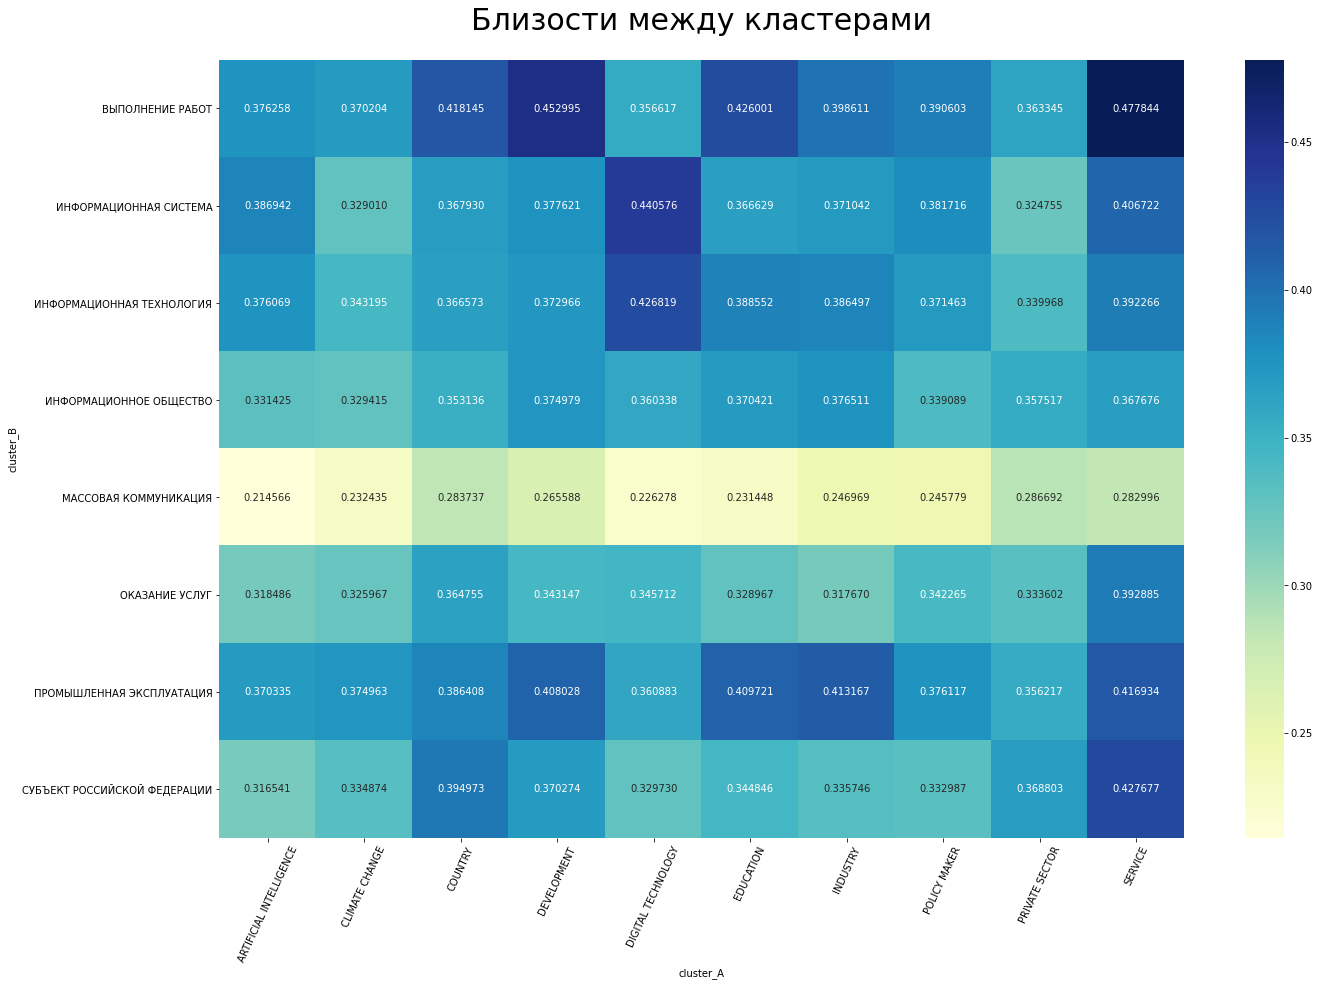

In [ ]:
freq_data = pd.read_csv('./Terms_similarities_table.csv')
freq_data = Term_similarity_table
# getting rid of small similarities

# in all dataset
perc_value = 5
percentile_5 = np.percentile(freq_data.Similarity.values, [perc_value])[0]
selected_data = freq_data[freq_data.Similarity > percentile_5]

# inside of each A cluster
for i in selected_data['cluster_A'].unique():
    temp_dataset = selected_data[selected_data.cluster_A == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_A'] == i) &
                                     (selected_data['Similarity'] < percentile_5)].index, inplace=True)

# inside of each B cluster
for i in selected_data['cluster_B'].unique():
    temp_dataset = selected_data[selected_data.cluster_B == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_B'] == i) &
                                    (selected_data['Similarity'] < percentile_5)].index, inplace=True)


# visualizing and saving tables
methods = ["average"]
title = "Близости между кластерами"

for method in methods:
    data = create_data(freq_data, method, method) #selected_data
    create_and_save_plots(data, title, method)


And also RoBERTa

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

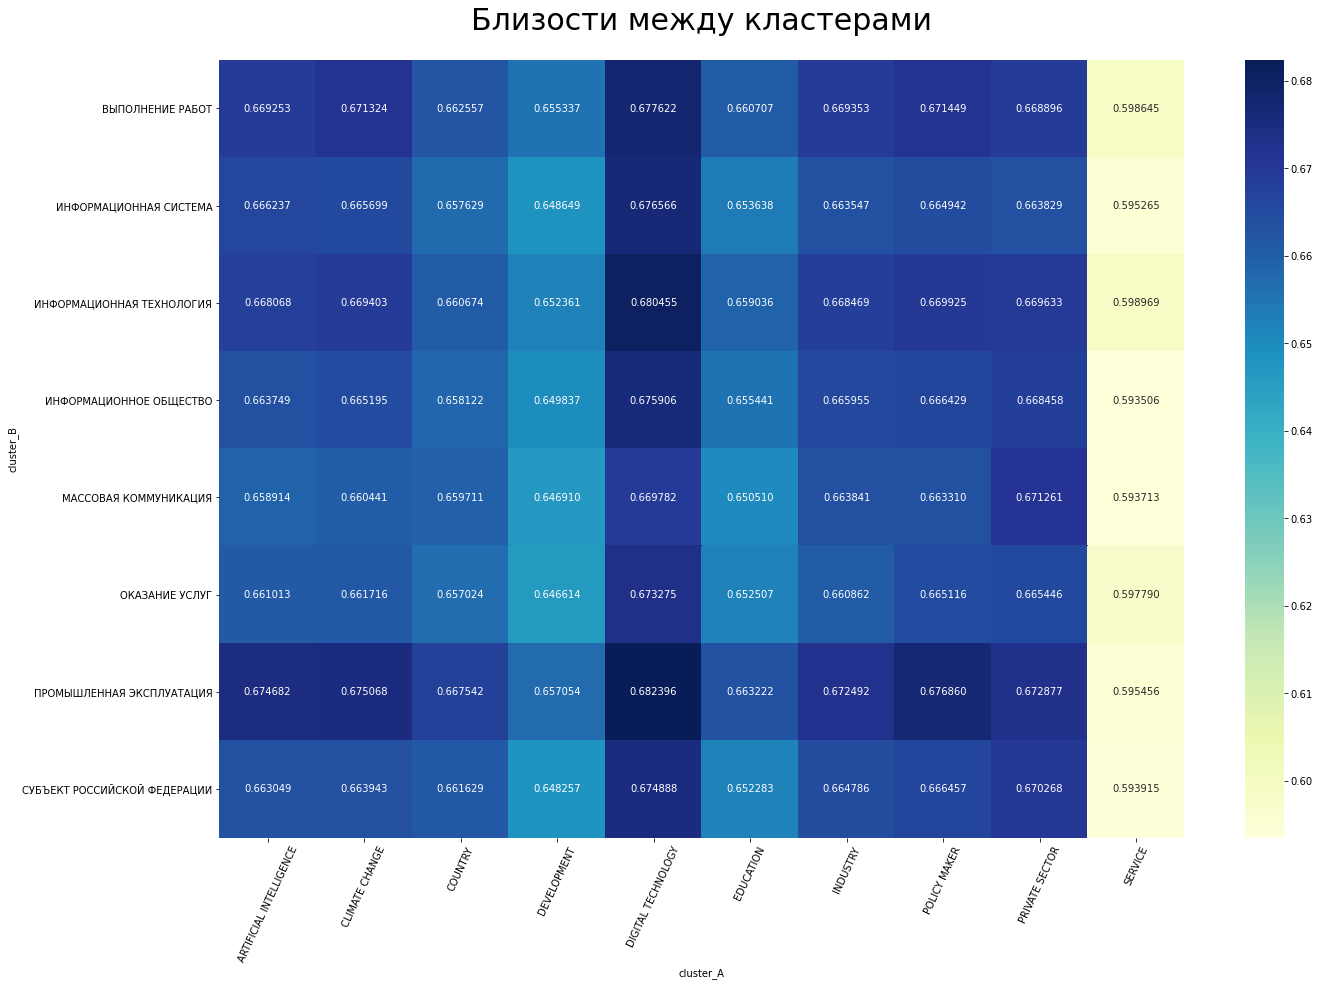

In [ ]:
freq_data = pd.read_csv('./Terms_similarities_table.csv')
freq_data = Term_similarity_table
# getting rid of small similarities

# in all dataset
perc_value = 5
percentile_5 = np.percentile(freq_data.Similarity.values, [perc_value])[0]
selected_data = freq_data[freq_data.Similarity > percentile_5]

# inside of each A cluster
for i in selected_data['cluster_A'].unique():
    temp_dataset = selected_data[selected_data.cluster_A == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_A'] == i) &
                                     (selected_data['Similarity'] < percentile_5)].index, inplace=True)

# inside of each B cluster
for i in selected_data['cluster_B'].unique():
    temp_dataset = selected_data[selected_data.cluster_B == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_B'] == i) &
                                    (selected_data['Similarity'] < percentile_5)].index, inplace=True)


# visualizing and saving tables
methods = ["average"]
title = "Близости между кластерами"

for method in methods:
    data = create_data(freq_data, method, method) #selected_data
    create_and_save_plots(data, title, method)


Oh, looks corrupted(((((
  

And the second trial is with the tuned one

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

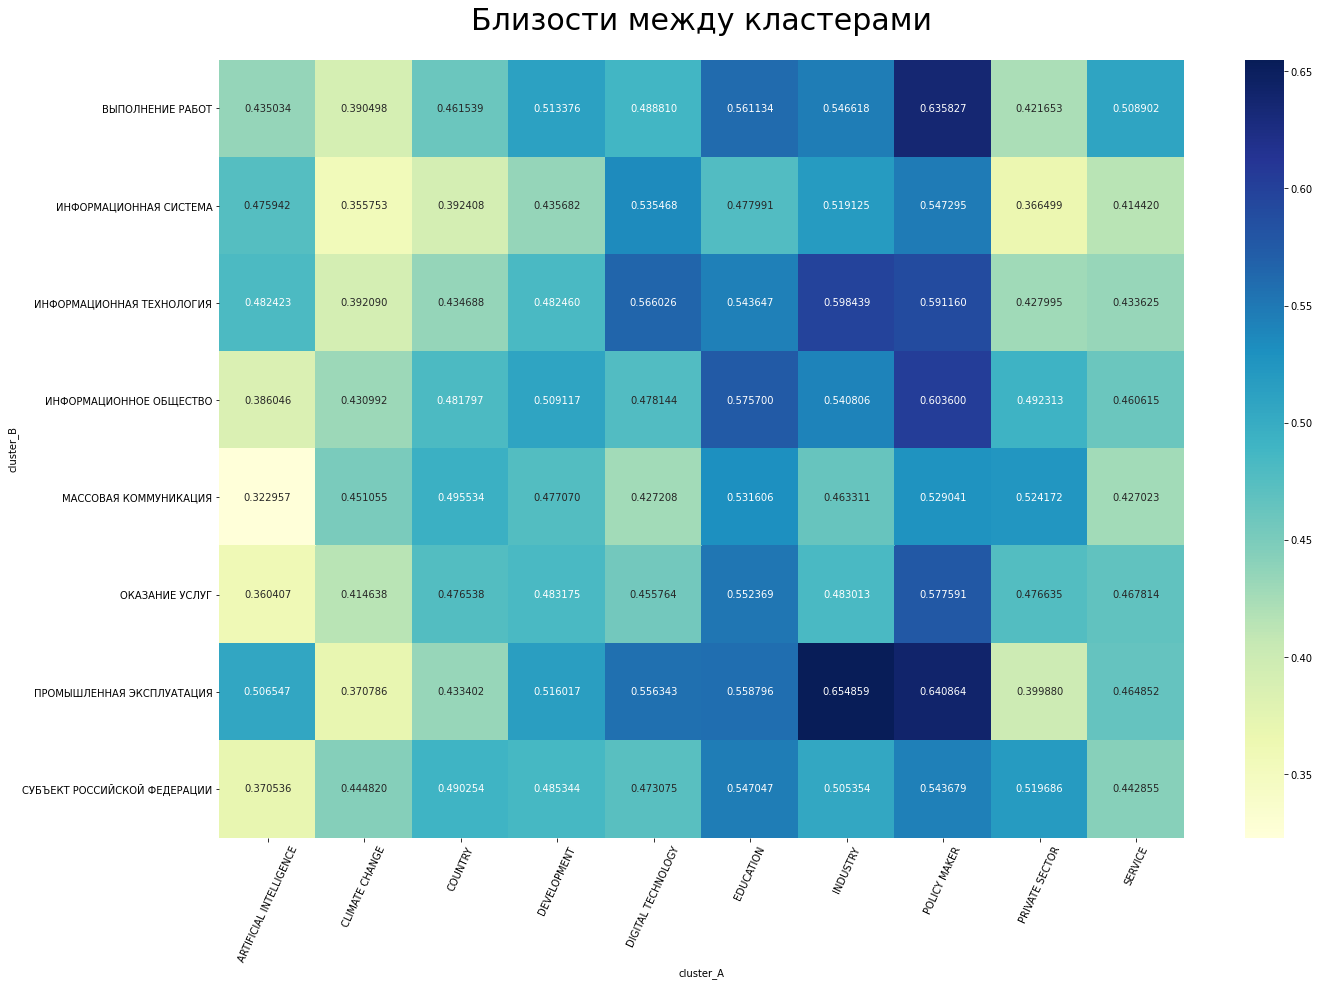

In [ ]:
freq_data = pd.read_csv('./Terms_similarities_table.csv')
freq_data = Term_similarity_table
# getting rid of small similarities

# in all dataset
perc_value = 5
percentile_5 = np.percentile(freq_data.Similarity.values, [perc_value])[0]
selected_data = freq_data[freq_data.Similarity > percentile_5]

# inside of each A cluster
for i in selected_data['cluster_A'].unique():
    temp_dataset = selected_data[selected_data.cluster_A == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_A'] == i) &
                                     (selected_data['Similarity'] < percentile_5)].index, inplace=True)

# inside of each B cluster
for i in selected_data['cluster_B'].unique():
    temp_dataset = selected_data[selected_data.cluster_B == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_B'] == i) &
                                    (selected_data['Similarity'] < percentile_5)].index, inplace=True)


# visualizing and saving tables
methods = ["average"]
title = "Близости между кластерами"

for method in methods:
    data = create_data(freq_data, method, method) #selected_data
    create_and_save_plots(data, title, method)


I am not sure, but looks better, at least

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.p

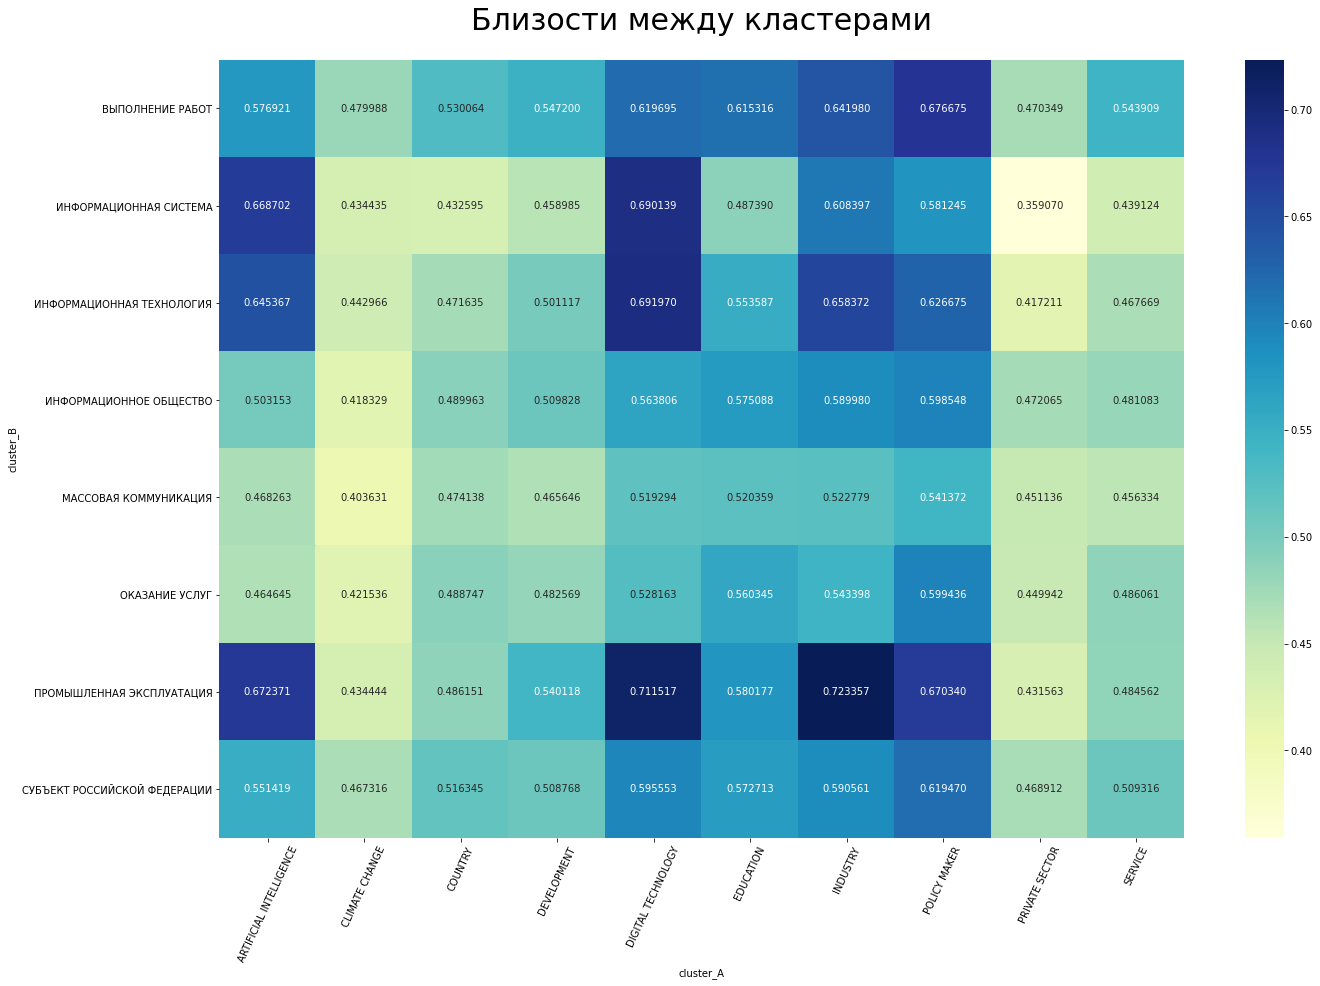

In [ ]:
freq_data = pd.read_csv('./Terms_similarities_table.csv')
freq_data = Term_similarity_table
# getting rid of small similarities

# in all dataset
perc_value = 5
percentile_5 = np.percentile(freq_data.Similarity.values, [perc_value])[0]
selected_data = freq_data[freq_data.Similarity > percentile_5]

# inside of each A cluster
for i in selected_data['cluster_A'].unique():
    temp_dataset = selected_data[selected_data.cluster_A == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_A'] == i) &
                                     (selected_data['Similarity'] < percentile_5)].index, inplace=True)

# inside of each B cluster
for i in selected_data['cluster_B'].unique():
    temp_dataset = selected_data[selected_data.cluster_B == i]
    percentile_5 = np.percentile(temp_dataset.Similarity.values, [perc_value])[0]
    selected_data.drop(selected_data[(selected_data['cluster_B'] == i) &
                                    (selected_data['Similarity'] < percentile_5)].index, inplace=True)


# visualizing and saving tables
methods = ["average"]
title = "Близости между кластерами"

for method in methods:
    data = create_data(freq_data, method, method) #selected_data
    create_and_save_plots(data, title, method)

Let's also look at most simmilar/dissimilar terms

In [ ]:
Terms = pd.DataFrame(list(zip(Term_similarity_table.Term_pair.apply(lambda x: x.split('/')[0]), Term_similarity_table.Term_pair.apply(lambda x: x.split('/')[1]), Term_similarity_table.Similarity.values)), columns=['Eng', 'Ru', 'Similarity'])
Terms.sort_values(by='Similarity', ascending=False,inplace=True)
Terms.to_csv('Terms_sim.csv', index=False)

Original:

In [ ]:
Terms[:30]

,Eng,Ru,Similarity
26743,TECHNOLOGICAL SOLUTION,ТЕХНОЛОГИЧЕСКОЕ РЕШЕНИЕ,0.995724
3389,DIGITAL TRANSFORMATION,ЦИФРОВАЯ ТРАНСФОРМАЦИЯ,0.993916
2262,SOCIAL NETWORK,СОЦИАЛЬНАЯ СЕТЬ,0.992158
81655,INFORMATION TECHNOLOGY,ИНФОРМАЦИОННАЯ ТЕХНОЛОГИЯ,0.986972
78849,INTELLECTUAL PROPERTY,ИНТЕЛЛЕКТУАЛЬНАЯ СОБСТВЕННОСТЬ,0.986034
21811,ARTIFICIAL INTELLIGENCE,ИСКУССТВЕННЫЙ ИНТЕЛЛЕКТ,0.975368
83746,INFORMATION TECHNOLOGY,ИСПОЛЬЗОВАНИЕ ИНФОРМАЦИОННЫХ ТЕХНОЛОГИЙ,0.974064
6146,INFORMATION SOCIETY,ИНФОРМАЦИОННОЕ ОБЩЕСТВО,0.970788
3737,INFORMATION SECURITY,ИНФОРМАЦИОННАЯ БЕЗОПАСНОСТЬ,0.969073
23792,BIG DATA,БОЛЬШИЕ ДАННЫЕ,0.966394


In [ ]:
Terms[-30:]

,Eng,Ru,Similarity
58094,PUBLIC AND PRIVATE SECTOR,МИНПРОМТОРГ РОССИИ,-0.065163
9339,INTERNET CONNECTION,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,-0.066040
9340,INTERNET CONNECTION,ПРЕЗИДЕНТ РОССИЙСКОЙ ФЕДЕРАЦИИ,-0.066895
51664,SOCIAL CHALLENGE,ПРЕЗИДЕНТ РОССИЙСКОЙ ФЕДЕРАЦИИ,-0.067054
20476,CHALLENGE,ПРЕЗИДЕНТ РОССИЙСКОЙ ФЕДЕРАЦИИ,-0.067131
73722,LOCAL PARTNER,МИНПРОМТОРГ РОССИИ,-0.069118
22316,SELF DRIVE CAR,БОЛЬШИЙ ОБЪЁМ ДАННЫХ,-0.069866
26187,SELF DRIVE CAR,ПОСТОЯННАЯ ОСНОВА,-0.071751
51957,40 DAY PERIOD,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ,-0.073119
57740,FUEL POVERTY,РОССИЙСКИЙ СЕГМЕНТ СЕТИ,-0.073348


Tuned:

In [ ]:
Terms[:30]

,Eng,Ru,Similarity
78849,INTELLECTUAL PROPERTY,ИНТЕЛЛЕКТУАЛЬНАЯ СОБСТВЕННОСТЬ,0.995542
3726,COMMUNICATION TECHNOLOGY,КОММУНИКАЦИОННАЯ ТЕХНОЛОГИЯ,0.993773
29734,IMPLEMENTATION FRAMEWORK,РАМКА РЕАЛИЗАЦИИ,0.993646
81655,INFORMATION TECHNOLOGY,ИНФОРМАЦИОННАЯ ТЕХНОЛОГИЯ,0.991037
30949,DECISION MAKING,ПРИНЯТИЕ РЕШЕНИЙ,0.990458
52744,FEDERAL LEVEL,ФЕДЕРАЛЬНЫЙ УРОВЕНЬ,0.986889
26743,TECHNOLOGICAL SOLUTION,ТЕХНОЛОГИЧЕСКОЕ РЕШЕНИЕ,0.983149
2262,SOCIAL NETWORK,СОЦИАЛЬНАЯ СЕТЬ,0.983017
3138,BROADBAND ACCESS,ШИРОКОПОЛОСНЫЙ ДОСТУП,0.981919
3737,INFORMATION SECURITY,ИНФОРМАЦИОННАЯ БЕЗОПАСНОСТЬ,0.981530


In [ ]:
Terms[-30:]

,Eng,Ru,Similarity
19135,STRENGTH,КОММУНАЛЬНОЕ ХОЗЯЙСТВО,-0.436749
29130,SCOTTISH BODY,ОКАЗАНИЕ УСЛУГ,-0.437136
41912,EXPERIMENTAL SPACE,ГОСУДАРСТВЕННАЯ ПОДДЕРЖКА,-0.437520
55429,NORTHERN IRELAND,ПРЕДОСТАВЛЕНИЕ УСЛУГ,-0.437662
55995,AUSTRALIA,ТЕЛЕКОММУНИКАЦИОННАЯ ИНФРАСТРУКТУРА,-0.438350
53006,NORTHERN IRELAND,ОКАЗАНИЕ УСЛУГ,-0.438541
30663,TRANSPARENCY,ПРИНЯТИЕ РЕШЕНИЙ,-0.441397
51060,TRANSPARENCY,ГОСУДАРСТВЕННОЕ УПРАВЛЕНИЕ,-0.442188
4992,FULL FIBRE,ТЕЛЕКОММУНИКАЦИОННАЯ ИНФРАСТРУКТУРА,-0.445005
35910,WELSH BODY,ТЕЛЕКОММУНИКАЦИОННАЯ СЕТЬ,-0.446847


## Some visualizations

In [ ]:
imp_terms_en = []
for i in data_en['Термин'].unique():
  imp_terms_en.append((i, data_en[data_en['Термин']==i]['Значимость'].iloc[0]))

imp_terms_ru = []
for i in data_ru['Термин'].unique():
  imp_terms_ru.append((i, data_ru[data_ru['Термин']==i]['Значимость'].iloc[0]))

imp_terms_en.sort(key=lambda x:x[1], reverse=True)
imp_terms_en = list(map(lambda x: x[0].lower(), imp_terms_en))

imp_terms_ru.sort(key=lambda x:x[1], reverse=True)
imp_terms_ru = list(map(lambda x: x[0].lower(), imp_terms_ru))

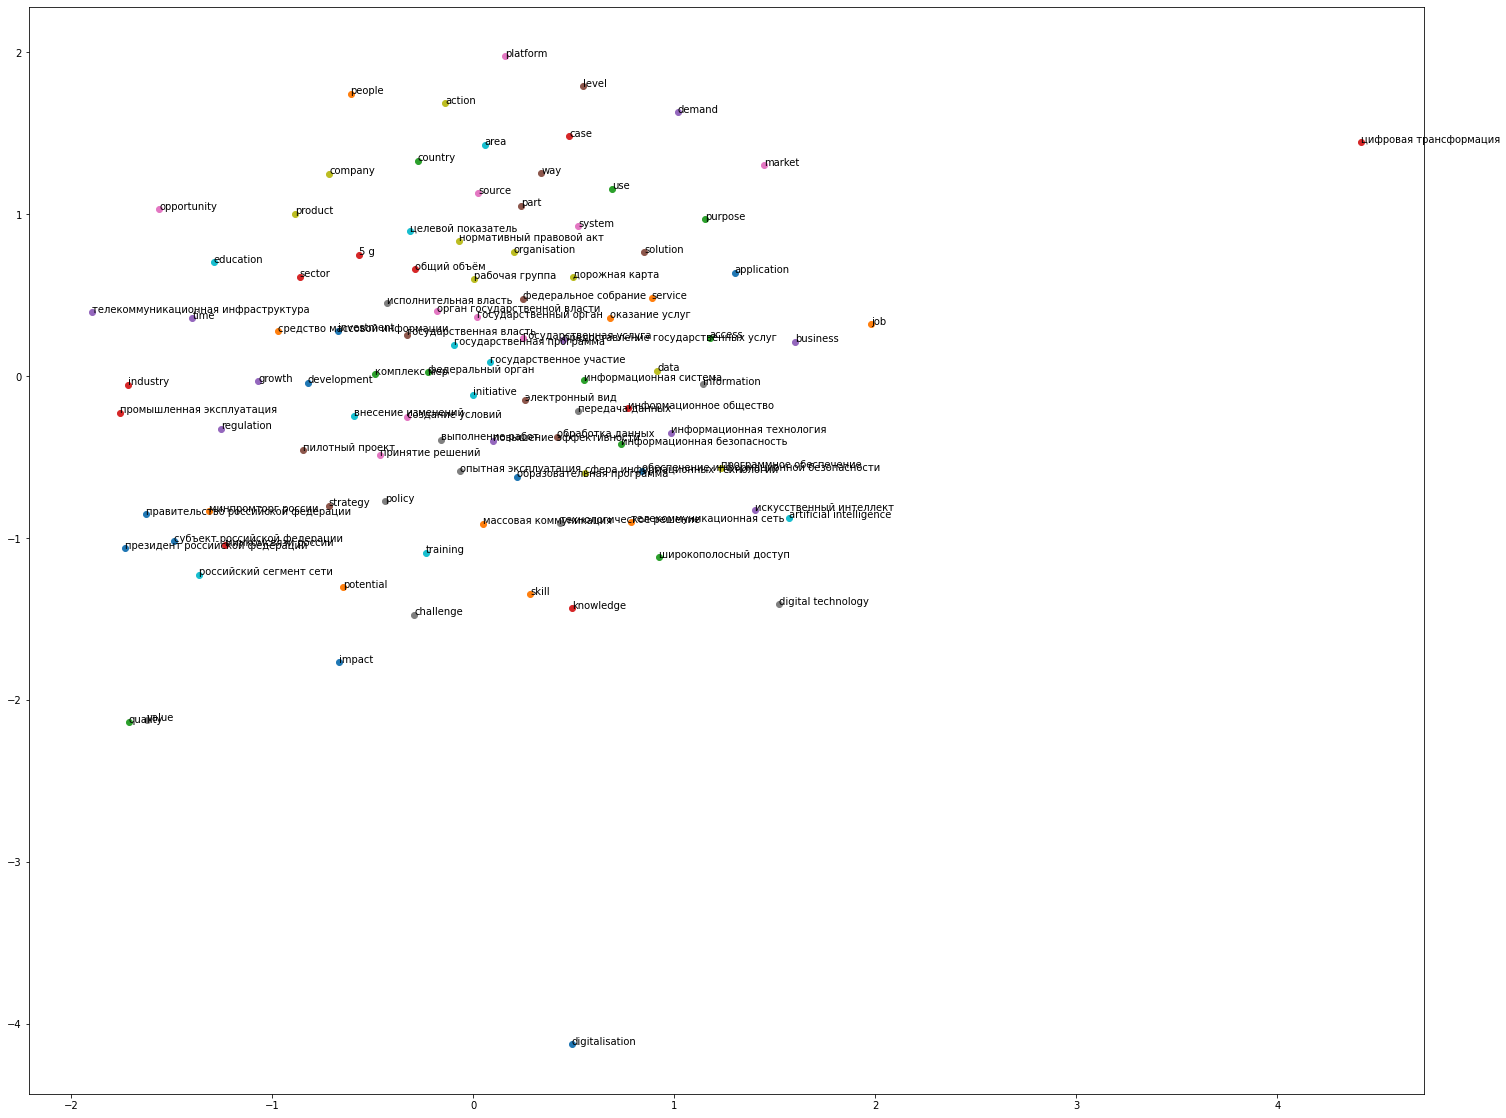

In [ ]:
vocab1 = [x for x in imp_terms_en[:50]] 
vocab2 = [x for x in imp_terms_ru[:50]]
all_vocab = vocab1+vocab2


def visualize(vocab1, vocab2):
  emb1 = [termsA[word] for word in vocab1]
  emb2 = [termsB[word] for word in vocab2]
  emb_tuple = tuple(emb1 + emb2)
  X_vis = np.vstack(emb_tuple)

  model_tsne = TSNE(n_components=2, random_state=0)
  np.set_printoptions(suppress=True)

  X_tsne = model_tsne.fit_transform(X_vis)
  from sklearn.preprocessing import StandardScaler
  ss = StandardScaler().fit(X_tsne)
  X_tsne1 = ss.transform(X_tsne)
  cur = 0
  fig = plt.figure(figsize=(25, 20))
  for word in all_vocab:
    #word_labels = [word for word in part]
    plt.scatter(X_tsne1[cur, 0], X_tsne1[cur, 1])
    #for i, word in enumerate(word_labels):
    plt.annotate(word, (X_tsne1[cur, 0], X_tsne1[cur, 1]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    cur += 1
  plt.show()

visualize(vocab1, vocab2)

Sure, it is not the best visualization, but we can see something 

And the tuned model:

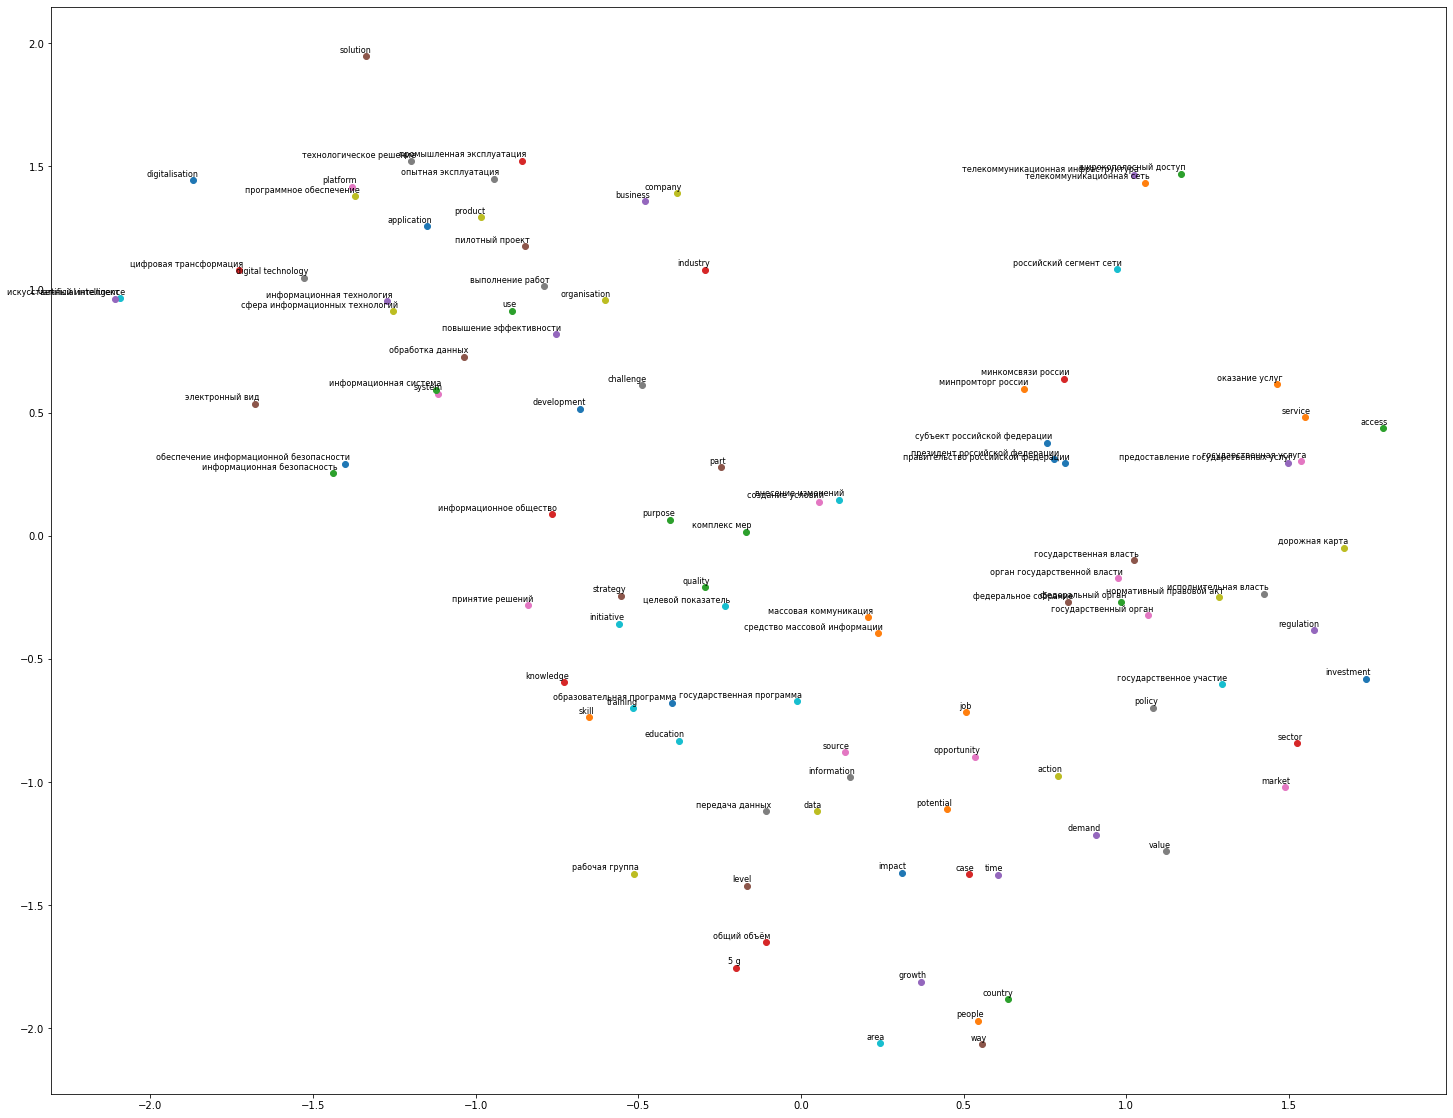

In [ ]:
vocab1 = [x for x in imp_terms_en[:50]] 
vocab2 = [x for x in imp_terms_ru[:50]]
all_vocab = vocab1+vocab2

visualize(vocab1, vocab2)

Also, the whole data

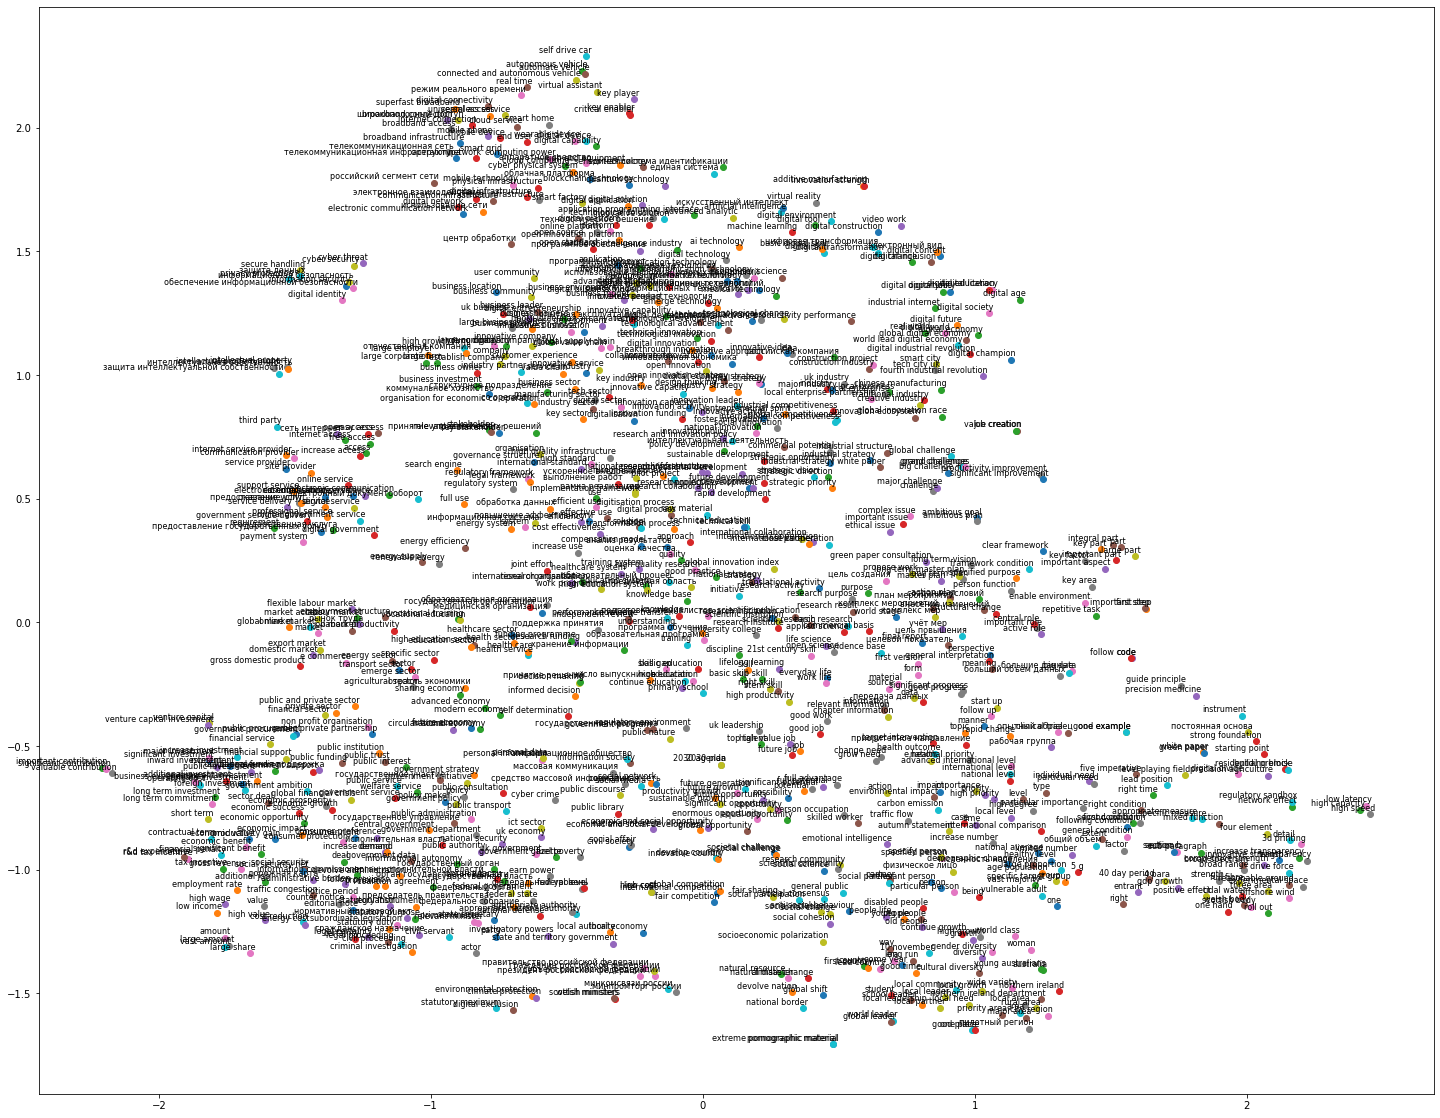

In [ ]:
vocab1 = [x for x in imp_terms_en]
vocab2 = [x for x in imp_terms_ru]
all_vocab = vocab1+vocab2

visualize(vocab1, vocab2)

Idk but the latter looks better imho

One more visualization

In [ ]:
emb1 = [termsA[word] for word in vocab1]
emb2 = [termsB[word] for word in vocab2]
emb_tuple = tuple(emb1 + emb2)
X_vis = np.vstack(emb_tuple)

model_tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)

X_tsne = model_tsne.fit_transform(X_vis)
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(X_tsne)
X_tsne1 = ss.transform(X_tsne)

Again, original

In [ ]:
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })
    
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig


draw_vectors(X_tsne1[:, 0], X_tsne1[:, 1], token=all_vocab)

Figure(id='1622', ...)

And the tuned

In [ ]:
output_notebook()

draw_vectors(X_tsne1[:, 0], X_tsne1[:, 1], token=all_vocab)

Figure(id='1347', ...)